# 2022-02-21 • Image, window, test

The simulation code of the previous notebook has been added to `pkg/VoltageToMap/src/`, and is imported below.

## Setup

In [1]:
# using Pkg; Pkg.resolve()

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltageToMap

## Params & sim

Short warm-up run. Get compilation out of the way.

In [5]:
p0 = SimParams(
    poisson_input = small_N__as_in_Python_2021,
    sim_duration  = 1*minutes
);

In [6]:
@time sim(p0);

  2.684890 seconds (7.23 M allocations: 482.248 MiB, 5.31% gc time, 93.64% compilation time)


In [13]:
p = SimParams(
    poisson_input = realistic_input,
    sim_duration  = 10*minutes,
    Δg_multiplier = 0.066,
)
dump(p)  # more descriptive (names, not just values) but also taking more space.

SimParams
  sim_duration: Float64 600.0
  Δt: Float64 0.0001
  num_timesteps: Int64 6000000
  poisson_input: PoissonInputParams
    N_unconn: Int64 100
    N_exc: Int64 5200
    N_inh: Int64 1300
    N_conn: Int64 6500
    N: Int64 6600
    spike_rate: Distributions.LogNormal{Float64}
      μ: Float64 1.0862943611198905
      σ: Float64 0.7745966692414834
  synapses: SynapseParams
    g_t0: Float64 0.0
    τ_s: Float64 0.007
    E_exc: Float64 0.0
    E_inh: Float64 -0.065
    Δg_exc: Float64 4.0000000000000007e-10
    Δg_inh: Float64 1.6000000000000003e-9
  izh_neuron: IzhNeuronParams
    C: Float64 1.0e-10
    k: Float64 7.0e-7
    vr: Float64 -0.06
    vt: Float64 -0.04
    a: Float64 30.0
    b: Float64 -2.0e-9
    v_peak: Float64 0.035
    v_reset: Float64 -0.05
    Δu: Float64 1.0e-10
    v_t0: Float64 -0.06
    u_t0: Float64 0.0
  Δg_multiplier: Float64 0.066
  seed: Int64 2022


In [8]:
t, v, input_spikes = @time sim(p);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:51mmm9mmmm9mmmmm


173.195922 seconds (24.14 M allocations: 2.302 GiB, 0.28% gc time, 1.40% compilation time)


In [9]:
num_spikes = length.(input_spikes)

ComponentVector{Int64}(conn = (exc = [931, 526, 658, 1256, 1091, 381, 622, 356, 877, 854  …  1133, 621, 575, 861, 717, 654, 887, 1198, 849, 895], inh = [887, 898, 816, 637, 1227, 1076, 1096, 634, 538, 518  …  569, 1182, 721, 882, 1271, 984, 793, 769, 333, 1259]), unconn = [1404, 881, 992, 1227, 951, 632, 1242, 1004, 810, 716  …  518, 309, 1253, 617, 1221, 646, 1502, 1047, 693, 586])

## Plot

In [14]:
import PyPlot
using Sciplotlib

In [15]:
""" tzoom = [200ms, 600ms] e.g. """
function plotsig(t, sig, tzoom = nothing; ax = nothing, clip_on=false, kw...)
    isnothing(tzoom) && (tzoom = t[[1, end]])
    izoom = first(tzoom) .≤ t .≤ last(tzoom)
    if isnothing(ax)
        plot(t[izoom], sig[izoom]; clip_on, kw...)
    else
        plot(t[izoom], sig[izoom], ax; clip_on, kw...)
    end
end;

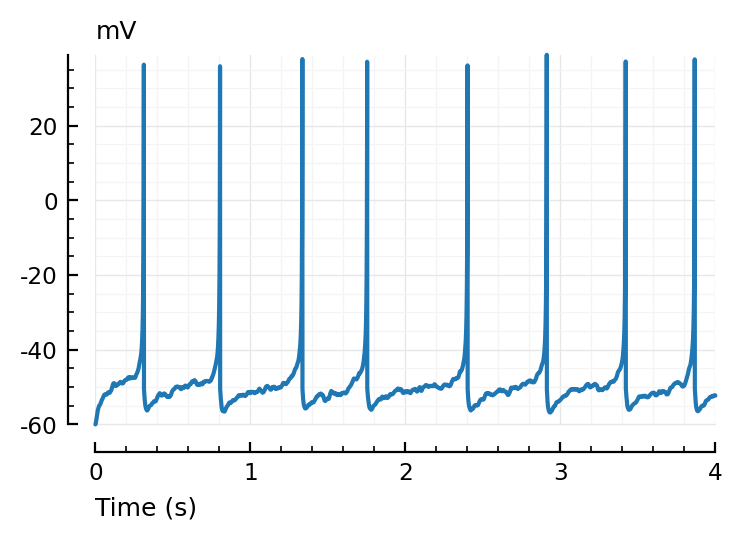

In [16]:
plotsig(t, v/mV, [0s, 4seconds], xlabel="Time (s)", hylabel="mV");

## Imaging noise

In [20]:
izh_params = cortical_RS

imaging_spike_SNR  #=::Float64=#  = 20
spike_height       #=::Float64=#  = izh_params.v_peak - izh_params.vr
σ_noise            #=::Float64=#  = spike_height / imaging_spike_SNR;

In [21]:
noise = randn(length(v)) * σ_noise
vimsig = v + noise;

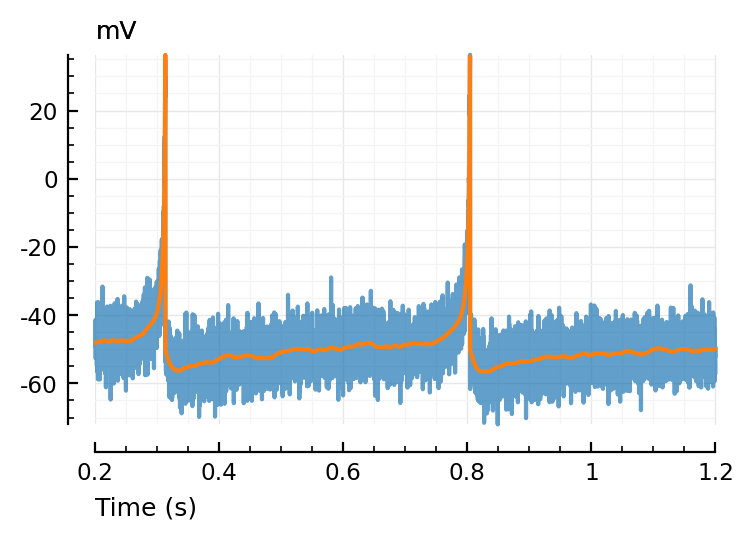

In [22]:
ax = plotsig(t, vimsig / mV, [200ms,1200ms], xlabel="Time (s)", hylabel="mV", alpha=0.7);
plotsig(t, v / mV, [200ms,1200ms], xlabel="Time (s)", hylabel="mV"; ax);

## Window

In [23]:
window_duration    #=::Float64=#  = 100 * ms;

In [24]:
const Δt = p.Δt
const win_size = round(Int, window_duration / Δt)
const t_win = linspace(zero(window_duration), window_duration, win_size)

function calc_STA(presynaptic_spikes)
    STA = zeros(eltype(vimsig), win_size)
    win_starts = round.(Int, presynaptic_spikes / Δt)
    num_wins = 0
    for a in win_starts
        b = a + win_size - 1
        if b ≤ lastindex(vimsig)
            STA .+= @view vimsig[a:b]
            num_wins += 1
        end
    end
    STA ./= num_wins
    return STA
end;

In [25]:
function plotSTA(presynspikes)
    STA = calc_STA(presynspikes)
    plot(t_win/ms, STA/mV)
end;

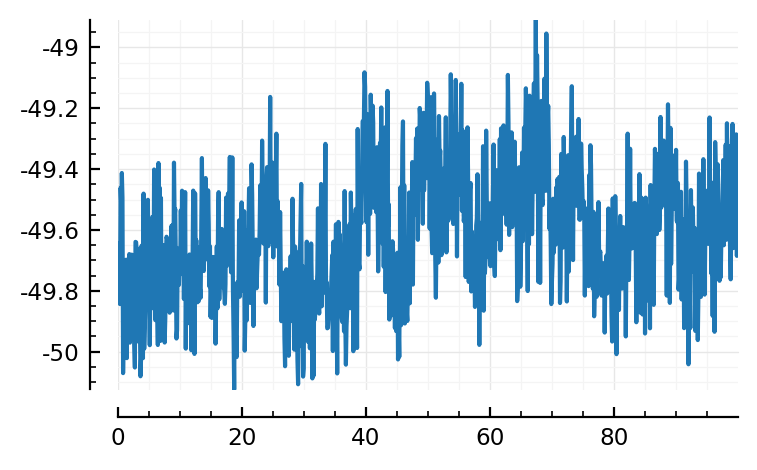

In [26]:
presynspikes = input_spikes.conn.exc[44]
plotSTA(presynspikes);

## Test connection

In [27]:
num_shuffles       #=::Int    =#  = 100;

In [28]:
to_ISIs(spiketimes) = [first(spiketimes); diff(spiketimes)]  # copying
to_spiketimes!(ISIs) = cumsum!(ISIs, ISIs)                   # in place

(presynspikes |> to_ISIs |> to_spiketimes!) ≈ presynspikes   # test

true

In [29]:
shuffle_ISIs(spiketimes) = to_spiketimes!(shuffle!(to_ISIs(spiketimes)));

In [30]:
test_statistic(spiketimes) = spiketimes |> calc_STA |> mean;

Note difference with 2021: there it was peak-to-peak (max - min). Here it is mean.

In [31]:
function test_connection(presynspikes)
    real_t = test_statistic(presynspikes)
    shuffled_t = Vector{typeof(real_t)}(undef, num_shuffles)
    for i in eachindex(shuffled_t)
        shuffled_t[i] = test_statistic(shuffle_ISIs(presynspikes))
    end
    N_shuffled_larger = count(shuffled_t .> real_t)
    return if N_shuffled_larger == 0
        p_value = 1 / num_shuffles
    else
        p_value = N_shuffled_larger / num_shuffles
    end
end;

## Results

In [34]:
resetrng!(20220222);

In [35]:
num_trains = 40
println("Average p(shuffled trains with higher STA mean).")
println("(N = $(num_trains) input spike trains per category)")

p_exc    = Float64[]
p_inh    = Float64[]
p_unconn = Float64[]

for (groupname, spiketrains, pvals) in (
        ("excitatory",    input_spikes.conn.exc, p_exc),
        ("inhibitory",    input_spikes.conn.inh, p_inh),
        ("unconnected",   input_spikes.unconn, p_unconn),
    )
    for spiketrain in spiketrains[1:num_trains]
        push!(pvals, test_connection(spiketrain))
        print("."); flush(stdout)
    end
    @printf "%12s: %.3g\n" groupname mean(pvals)
end

Average p(shuffled trains with higher mean).
(N = 40 input spike trains per category)
........................................  excitatory: 0.416
........................................  inhibitory: 0.716
........................................ unconnected: 0.508


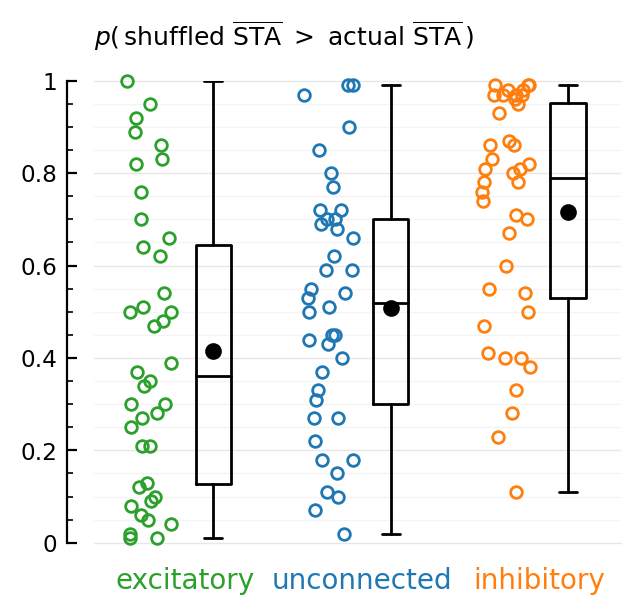

In [105]:
fig, ax = plt.subplots(figsize=(3.4,3))
function plotdot(y, x, c, jitter=0.28)
    N = length(y)
    x -= 0.35
    plot(x*ones(N) + (rand(N).-0.5)*jitter, y, "o", color=c, ms=4.2, markerfacecolor="none", clip_on=false)
    plot(x+0.35, mean(y), "k.", ms=10)
end
plotdot(p_exc,    1, "C2"); ax.text(1-0.16, -0.1, "excitatory"; color="C2", ha="center")
plotdot(p_unconn, 2, "C0"); ax.text(2-0.16, -0.1, "unconnected"; color="C0", ha="center")
plotdot(p_inh,    3, "C1"); ax.text(3-0.16, -0.1, "inhibitory"; color="C1", ha="center")
ax.boxplot([p_exc, p_unconn, p_inh], widths=0.2, medianprops=Dict("color"=>"black"))
set(ax, xlim=(0.33, 3.3), ylim=(0, 1), xaxis=:off)
hylabel(ax, L"p(\, \mathrm{shuffled\ \overline{STA}} \ > \ \mathrm{actual\ \overline{STA}}\, )"; dy=10);

Proportion of shuffled spike trains for which `mean(STA)` is higher than the unshuffled spike train.

Excitatory (green), unconnected (blue), and inhibitory (orange) input neurons.


10-minute simulation with a total of 6500 connected input neurons.